<a href="https://colab.research.google.com/github/56sarager/QFT-Finance/blob/main/QFT_Asset_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quantum Field theoretic Asset Pricing
Below is an interactive Google Colab for the work of Belal E. Baaquie based mostly on Chapter 6 Path Integral of Asset Prices of his book $\textit{Quantum Field Theory for Economics and Finance}$ sourced below. Baaquie derives the correlation function $D(t)=\frac{1}{\sin(\phi)}e^{-\omega t \cos(phi)}\sin(\phi + \omega t \sin(\phi))$ using quantum field theoretic techniques from the general form of a microeconomic potential $V(p)=\begin{cases} D(p) & p_i \rightarrow 0 \\ S(p) & p_i \rightarrow \infty \end{cases}$ (Supply increases as price increase because their is a greater incentive to produce and demand increases as price decreases) along with a nonlinear kinetic term. The derivation is straight forward and can be found in Baaquie Chapter 6 (Chp. 6 pdf: https://www.cambridge.org/core/services/aop-cambridge-core/content/view/2117810C3129E3703E3D9D9E1D271143/9781108423151c6_101-146.pdf/path_integral_of_asset_prices.pdf). The first cell below allows one to play with the parameters of the model and get a sense of what the function looks like. $\lambda$ and $\eta$ are "market time" parameters as defined by Baaquie and provide the rescaling $t \rightarrow \lambda(\frac{t}{\lambda})^\eta$. The second cell below takes a ticker and a range of dates greater than or equal to 500 days, retrieves the corresponding data from Yahoo Finance, and plots the derived autocorrelation function fitted to market data. The market data is given by $G_{IJ}(n)=\frac{1}{2}[\frac{1}{N-k}\sum_{n=1}^{N-k}y_I(n)y_J(n+k)+\frac{1}{N-k}\sum_{n=1}^{N-k}y_J(n)y_I(n+k)$] where y(n) is closing price data and I,J correspond to tickers. For the autocorrelation, I=J. For the cross correlation fit, the first cell requests an input of two tickers and a range of datas greater than or equal to 500 days. The autocorrelation functions are calculated as in the single ticker case but for the same market time values of $\lambda$ and $\eta$. Then their cross correlation is found using $D_{IJ}(z(\tau))=\Delta_{ij}\int_{-\infty}^\infty dt D_{I}(t)D_{J}(t-z(\tau)), I \neq J$ where $z(\tau)$ is market time and the coupling constant $\Delta_{ij}$ is given by $\Delta_{ij}=\frac{G_{IJ}(0)}{\int_{-\infty}^\infty dt D_{I}(t)D_{J}(t)}=\frac{1}{\int_{-\infty}^\infty dt D_{I}(t)D_{J}(t)}, I \neq J$. Cell two of the multiple ticker dropdown plots market data for the inputed tickers and their cross correlation given by $G_{IJ}(n)$ along with their fitted autocorrelations and derived cross correlation. Cell three of the multiple ticker dropdown takes an additional four input tickers and plots all of their cross correlation coupling constants. It was desired to only require the user to input the original two tickers for the multiple ticker cross correaltion and provide the user with an additional four relevant tickers to be displayed in the coupling constant plot, but a robust solution was not found without using an API or scraping and searching through a large datset. As a final note, the values of $\phi, \omega, \lambda, \eta$ are used in this Colab, but Baaquie converts back to the parameters $\gamma, L, \tilde{L}$. This can be done using $\gamma=\frac{\omega}{4\cos(\phi)}, L=\frac{\gamma}{\omega^4}, \tilde{L}=\frac{1}{4\gamma}-2\sqrt{L\gamma}$.

#Single Ticker Autocorrelation Fit (I=J)
Note: The fourth cell with normalization between -0.4 and 1 is more robust than the third, as can be seen by manually adjusting the model parameters with the sliders of the first cell, because the periodic nature of the function requires it be allowed to take negative values in order to fully model nonlinear portions of the dataset.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider
from IPython.display import display, clear_output

# Define the function
def model_function(t, phi, omega, lambda_param, eta):
    # Using torch for calculations
    decay = lambda_param **(1-eta)* t ** eta
    return (1 / torch.sin(phi)) * torch.exp(-omega * decay * torch.cos(phi)) * torch.sin(phi + omega * decay * torch.sin(phi))

# Set up the interactive plotting function
def interactive_plot(phi, omega, lambda_param, eta):
    """
        D(t) = (1 / sin(phi)) * exp(-omega * lambda*(t/lambda)^eta * cos(phi)) * sin(phi + omega * lambda*(t/lambda)^eta * sin(phi))

    """
    t = torch.linspace(0, 1, 100)  # Define a range of t values

    # Calculate function values with the current phi and omega
    y = model_function(t, torch.tensor(phi), torch.tensor(omega), torch.tensor(lambda_param), torch.tensor(eta)).numpy()

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(t.numpy(), y, label=f'phi={phi}, omega={omega}, lambda={lambda_param}, eta={eta}', color='aquamarine')
    plt.xlabel('t (Normalized)')
    plt.ylabel('D(t)')
    plt.title('Derived Asset Correlation Function')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create sliders for phi and omega
phi_slider = FloatSlider(value=1.0, min=0.1, max=2*np.pi, step=0.05, description='phi')
omega_slider = FloatSlider(value=1.0, min=0.1, max=10, step=0.05, description='omega')
lambda_slider = FloatSlider(value=1.0, min=0.1, max=1, step=0.05, description='lambda')
eta_slider = FloatSlider(value=1.0, min=0.1, max=1, step=0.05, description='eta')

# Interactive plot with sliders
interact(interactive_plot, phi=phi_slider, omega=omega_slider, lambda_param=lambda_slider, eta=eta_slider)

interactive(children=(FloatSlider(value=1.0, description='phi', max=6.283185307179586, min=0.1, step=0.05), Fl…

<function __main__.interactive_plot(phi, omega, lambda_param, eta)>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Download stock data from Yahoo Finance
ticker_symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2015-01-01"
ticker_symbol = input(f"Enter the ticker symbol (default: {ticker_symbol}): ") or ticker_symbol
start_date = input(f"Enter the start date (default: {start_date}): ") or start_date
end_date = input(f"Enter the end date (atleast 500 days from start date, default: {end_date}): ") or end_date

data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1d")

Enter the ticker symbol (default: AAPL): 
Enter the start date (default: 2010-01-01): 
Enter the end date (atleast 500 days from start date, default: 2015-01-01): 


[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.4117893576622009, phi: 1.0099999904632568, omega: 1.0099999904632568
Epoch 1000, Loss: 0.08683465421199799, phi: 0.6468591094017029, omega: 5.753408432006836
Epoch 2000, Loss: 0.06679403781890869, phi: 0.7445153594017029, omega: 7.885696887969971
Epoch 3000, Loss: 0.06428690999746323, phi: 0.5251041054725647, omega: 8.94190788269043
Epoch 4000, Loss: 0.06330987066030502, phi: 0.23710553348064423, omega: 9.80695915222168


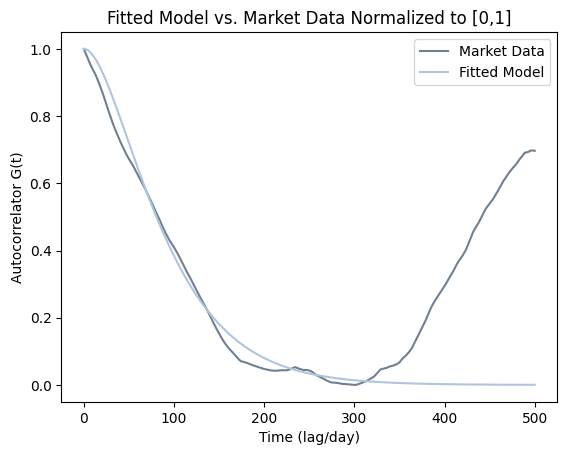

Epoch 0, Fine Loss: 0.06296592950820923, phi: -0.000710998778231442, omega: 10.421135902404785, lambda: 1.0, eta: 0.9990000128746033
Epoch 1000, Fine Loss: 0.053725842386484146, phi: 0.00014059009845368564, omega: 9.913869857788086, lambda: 0.20844461023807526, eta: 0.34796464443206787
Epoch 2000, Fine Loss: 0.053725846111774445, phi: 0.00014494938659481704, omega: 9.91386604309082, lambda: 0.2084447741508484, eta: 0.34796440601348877
Epoch 3000, Fine Loss: 0.053725846111774445, phi: 0.00017259770538657904, omega: 9.91386604309082, lambda: 0.20844478905200958, eta: 0.3479645550251007
Epoch 4000, Fine Loss: 0.053725846111774445, phi: 0.0003289886808488518, omega: 9.91386604309082, lambda: 0.20844468474388123, eta: 0.3479645848274231


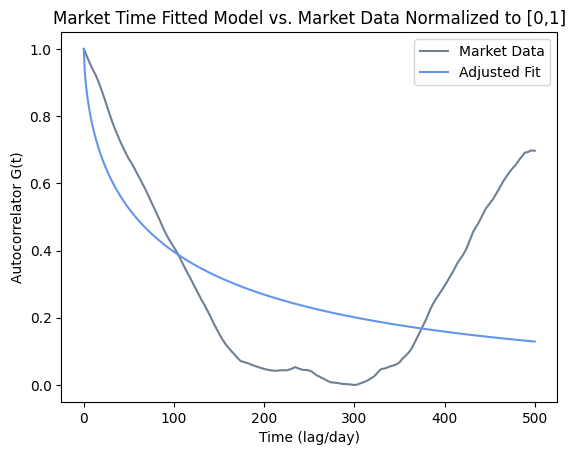

In [ ]:
# Normalization between 0 and 1 convenient but does not allow model to access full parameters
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare the data
y_prices = data['Close'].values[::-1].astype(np.float32)
N = len(y_prices)

# Step 2: Calculate the symmetrized autocorrelation G_{IJ}(\tau)
def calculate_G_symmetrized(y, max_lag):
    G_values = []
    for tau in range(1, max_lag + 1):  # tau = 1, 2, ..., max_lag
        sum_1 = sum(y[n] * y[n + tau] for n in range(N - tau))
        sum_2 = sum(y[n + tau] * y[n] for n in range(N - tau))
        G_tau = 0.5 * (1 / (N - tau)) * (sum_1 + sum_2)
        G_values.append(G_tau)
    return np.array(G_values)

# Set maximum lag and calculate G values
max_lag = 500
G_values = calculate_G_symmetrized(y_prices, max_lag)
G_values = G_values / (np.max(G_values) - np.min(G_values))
G_values = G_values - np.max(G_values) + 1  # Normalize by the first value

# Convert G_values to PyTorch tensors for fitting
G_tensor = torch.tensor(G_values).float().view(-1, 1)
t_vals = np.linspace(0, 1, len(G_values)).astype(np.float32)  # Normalized time axis for fitting
t_tensor = torch.tensor(t_vals).float().view(-1, 1)

# Define the model function
def model_function(t, phi, omega):
    return (1 / torch.sin(phi)) * torch.exp(-omega * t * torch.cos(phi)) * torch.sin(phi + omega * t * torch.sin(phi))

# Define the model parameters
phi = torch.tensor(1.0, requires_grad=True)  # Initial guess for phi
omega = torch.tensor(1.0, requires_grad=True)  # Initial guess for omega

# Define the optimizer
optimizer = optim.Adam([phi, omega], lr=0.01)
loss_fn = nn.MSELoss()

# Fit the model
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_fit = model_function(t_tensor, phi, omega)
    loss = loss_fn(y_fit, G_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, phi: {phi.item()}, omega: {omega.item()}")

# Plot the initial fit
plt.plot(t_vals*max_lag, G_values, label="Market Data", color='slategrey')
plt.plot(t_vals*max_lag, y_fit.detach().numpy(), label="Fitted Model", color='lightsteelblue')
plt.title("Fitted Model vs. Market Data Normalized to [0,1]")
plt.xlabel("Time (lag/day)")
plt.ylabel("Autocorrelator G(t)")
plt.legend()
plt.show()

# Fine adjustment with scaling transformation t -> lambda * (t/lambda)^eta
lambda_ = torch.tensor(1.0, requires_grad=True)
eta = torch.tensor(1.0, requires_grad=True)

# Define the adjusted model with rescaled time
def adjusted_model_function(t, phi, omega, lambda_, eta):
    t_rescaled = lambda_ **(1-eta)* t ** eta
    return (1 / torch.sin(phi)) * torch.exp(-omega * t_rescaled * torch.cos(phi)) * torch.sin(phi + omega * t_rescaled * torch.sin(phi))

# Fine-tuning optimizer
fine_optimizer = optim.Adam([phi, omega, lambda_, eta], lr=0.001)

# Fine-tuning loop
for epoch in range(epochs):
    fine_optimizer.zero_grad()
    y_fit_adjusted = adjusted_model_function(t_tensor, phi, omega, lambda_, eta)
    fine_loss = loss_fn(y_fit_adjusted, G_tensor)
    fine_loss.backward()
    fine_optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Fine Loss: {fine_loss.item()}, phi: {phi.item()}, omega: {omega.item()}, lambda: {lambda_.item()}, eta: {eta.item()}")

# Plot the final adjusted fit
plt.plot(t_vals*max_lag, G_values, label="Market Data", color='slategrey')
plt.plot(t_vals*max_lag, y_fit_adjusted.detach().numpy(), label="Adjusted Fit", color='cornflowerblue')
plt.title("Market Time Fitted Model vs. Market Data Normalized to [0,1]")
plt.xlabel("Time (lag/day)")
plt.ylabel("Autocorrelator G(t)")
plt.legend()
plt.show()

Epoch 0, Loss: 0.8795150518417358, phi: 1.0099999904632568, omega: 1.0099999904632568
Epoch 1000, Loss: 0.023835856467485428, phi: 1.388974666595459, omega: 6.397122383117676
Epoch 2000, Loss: 0.02310861088335514, phi: 1.377718210220337, omega: 6.564369201660156
Epoch 3000, Loss: 0.02310860902070999, phi: 1.377699375152588, omega: 6.564634799957275
Epoch 4000, Loss: 0.023108603432774544, phi: 1.3776987791061401, omega: 6.56464147567749


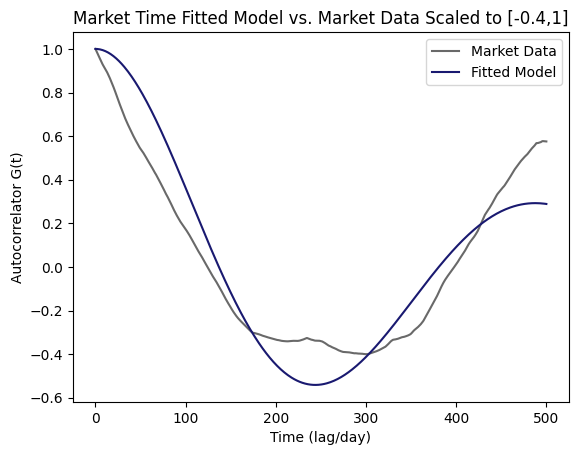

Epoch 0, Fine Loss: 0.023108607158064842, phi: 1.3786206245422363, omega: 6.56561279296875, lambda: 1.0, eta: 0.9990000128746033
Epoch 1000, Fine Loss: 0.01656016893684864, phi: 1.3641409873962402, omega: 6.4104814529418945, lambda: 0.7952927350997925, eta: 0.8588003516197205
Epoch 2000, Fine Loss: 0.01656016707420349, phi: 1.3641412258148193, omega: 6.4104814529418945, lambda: 0.7952924370765686, eta: 0.8588001728057861
Epoch 3000, Fine Loss: 0.01656017266213894, phi: 1.3641332387924194, omega: 6.410480976104736, lambda: 0.7952920794487, eta: 0.858799934387207
Epoch 4000, Fine Loss: 0.01656017079949379, phi: 1.3641308546066284, omega: 6.4104790687561035, lambda: 0.7952922582626343, eta: 0.858799934387207


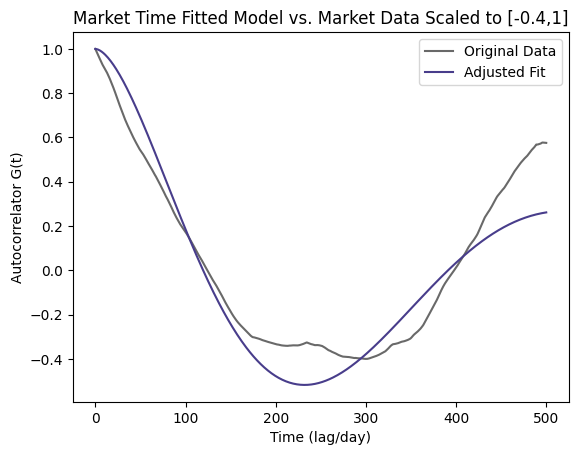

In [ ]:
# Normaliztion between [-0.4, 1] allows the fitted model to become negative and represent more nonlinear data
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare the data
y_prices = data['Close'].values[::-1].astype(np.float32)
N = len(y_prices)

# Step 2: Calculate the symmetrized autocorrelation G_{IJ}(\tau)
def calculate_G_symmetrized(y, max_lag):
    G_values = []
    for tau in range(1, max_lag + 1):  # tau = 1, 2, ..., max_lag
        sum_1 = sum(y[n] * y[n + tau] for n in range(N - tau))
        sum_2 = sum(y[n + tau] * y[n] for n in range(N - tau))
        G_tau = 0.5 * (1 / (N - tau)) * (sum_1 + sum_2)
        G_values.append(G_tau)
    return np.array(G_values)

# Set maximum lag and calculate G values
max_lag = 500
G_values = calculate_G_symmetrized(y_prices, max_lag)

# Normalize G_values between -0.4 and 1
min_val = np.min(G_values)
max_val = np.max(G_values)

# Rescale G_values to range [0, 1]
G_values_normalized = (G_values - min_val) / (max_val - min_val)

# Now, rescale to the range [-0.4, 1]
G_values_scaled = -0.4 + G_values_normalized * (1 + 0.4)

# Convert G_values to PyTorch tensors for fitting
G_tensor = torch.tensor(G_values_scaled).float().view(-1, 1)

# Create a normalized time axis for fitting
t_vals = np.linspace(0, 1, len(G_values)).astype(np.float32)  # Normalized time axis for fitting
t_tensor = torch.tensor(t_vals).float().view(-1, 1)

# Define the model function
def model_function(t, phi, omega):
    return (1 / torch.sin(phi)) * torch.exp(-omega * t * torch.cos(phi)) * torch.sin(phi + omega * t * torch.sin(phi))

# Define the model parameters
phi = torch.tensor(1.0, requires_grad=True)  # Initial guess for phi
omega = torch.tensor(1.0, requires_grad=True)  # Initial guess for omega

# Define the optimizer
optimizer = optim.Adam([phi, omega], lr=0.01)
loss_fn = nn.MSELoss()

# Fit the model
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_fit = model_function(t_tensor, phi, omega)
    loss = loss_fn(y_fit, G_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, phi: {phi.item()}, omega: {omega.item()}")

# Plot the initial fit
plt.plot(t_vals*max_lag, G_values_scaled, label="Market Data", color='dimgrey')
plt.plot(t_vals*max_lag, y_fit.detach().numpy(), label="Fitted Model", color='midnightblue')
plt.title("Fitted Model vs. Market Data Scaled to [-0.4,1]")
plt.xlabel("Time (lag/day)")
plt.ylabel("Autocorrelator G(t)")
plt.legend()
plt.show()

# Fine adjustment with scaling transformation t -> lambda * (t/lambda)^eta
lambda_ = torch.tensor(1.0, requires_grad=True)
eta = torch.tensor(1.0, requires_grad=True)

# Define the adjusted model with rescaled time
def adjusted_model_function(t, phi, omega, lambda_, eta):
    t_rescaled = lambda_ ** (1 - eta) * t ** eta
    return (1 / torch.sin(phi)) * torch.exp(-omega * t_rescaled * torch.cos(phi)) * torch.sin(phi + omega * t_rescaled * torch.sin(phi))

# Fine-tuning optimizer
fine_optimizer = optim.Adam([phi, omega, lambda_, eta], lr=0.001)

# Fine-tuning loop
for epoch in range(epochs):
    fine_optimizer.zero_grad()
    y_fit_adjusted = adjusted_model_function(t_tensor, phi, omega, lambda_, eta)
    fine_loss = loss_fn(y_fit_adjusted, G_tensor)
    fine_loss.backward()
    fine_optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Fine Loss: {fine_loss.item()}, phi: {phi.item()}, omega: {omega.item()}, lambda: {lambda_.item()}, eta: {eta.item()}")

# Plot the final adjusted fit
plt.plot(t_vals*max_lag, G_values_scaled, label="Market Data", color='dimgrey')
plt.plot(t_vals*max_lag, y_fit_adjusted.detach().numpy(), label="Adjusted Fit", color='darkslateblue')
plt.title("Market Time Fitted Model vs. Market Data Scaled to [-0.4,1]")
plt.xlabel("Time (lag/day)")
plt.ylabel("Autocorrelator G(t)")
plt.legend()
plt.show()

#Multiple Ticker Cross Correlation Fit (I$\neq$J)
Note: The scaling of the derived cross correlation is slightly off. It is clear to see that it replicates the trend of the cross correlation market data, but it would be better if the scale was corrected so the extrema align. (Possibly caused by numerical artifacts/ look into better was of computing the integral)

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Download stock data from Yahoo Finance
ticker_symbol1 = "AAPL"
ticker_symbol2 = "GOOG"
start_date = "2010-01-01"
end_date = "2015-01-01"
ticker_symbol1 = input(f"Enter the first ticker symbol (default: {ticker_symbol1}): ") or ticker_symbol1
ticker_symbol2 = input(f"Enter the second ticker symbol (default: {ticker_symbol2}): ") or ticker_symbol2
start_date = input(f"Enter the start date (default: {start_date}): ") or start_date
end_date = input(f"Enter the end date (atleast 500 days from start date, default: {end_date}): ") or end_date

data = yf.download(ticker_symbol1, start=start_date, end=end_date, interval="1d")
data2 = yf.download(ticker_symbol2, start=start_date, end=end_date, interval="1d")

Enter the first ticker symbol (default: AAPL): 
Enter the second ticker symbol (default: GOOG): 
Enter the start date (default: 2010-01-01): 
Enter the end date (atleast 500 days from start date, default: 2015-01-01): 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 1.47255277633667, phi_1: 1.0099999904632568, omega_1: 1.0099999904632568, phi_2: 1.0099999904632568, omega_2: 1.0099999904632568
Epoch 1000, Loss: 0.025559457018971443, phi_1: 1.388974666595459, omega_1: 6.397122383117676, phi_2: 1.2869691848754883, omega_2: 3.3607802391052246
Epoch 2000, Loss: 0.024530168622732162, phi_1: 1.377718210220337, omega_1: 6.564369201660156, phi_2: 1.2645524740219116, omega_2: 3.4868738651275635
Epoch 3000, Loss: 0.024530161172151566, phi_1: 1.377699375152588, omega_1: 6.564634799957275, phi_2: 1.264478325843811, omega_2: 3.4873030185699463
Epoch 4000, Loss: 0.02453015372157097, phi_1: 1.3776987791061401, omega_1: 6.56464147567749, phi_2: 1.2644776105880737, omega_2: 3.487306833267212
Epoch 0, Fine Loss: 0.024530157446861267, phi_1: 1.3782461881637573, omega_1: 6.565609455108643, phi_2: 1.2638508081436157, omega_2: 3.4882287979125977, lambda: 1.0, eta: 0.9990000128746033
Epoch 1000, Fine Loss: 0.01772501692175865, phi_1: 1.3646358251571655, om

<ipython-input-3-cb94c3af63bb>:135: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cross_correlation_value = simps(cross_product, t_vals)


Cross-Correlation Integral Value: 0.10865675772423299


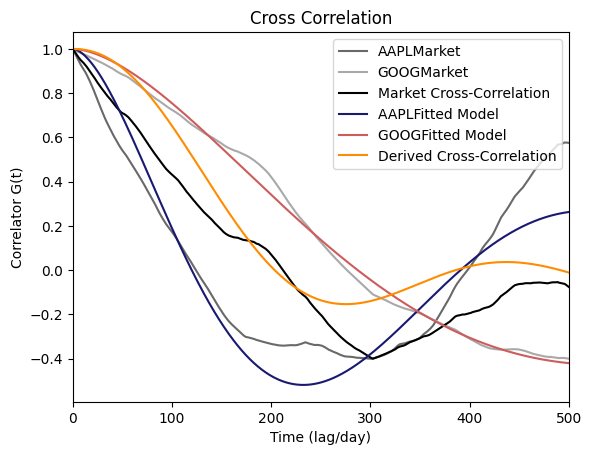

In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.integrate import cumtrapz

# Prepare the data
y_prices = data['Close'].values[::-1].astype(np.float32)
y_prices_2 = data2['Close'].values[::-1].astype(np.float32)  # Second dataset
N = len(y_prices)

# Step 2: Calculate the symmetrized autocorrelation G_{IJ}(\tau) for both datasets
def calculate_G_symmetrized(y, max_lag):
    G_values = []
    for tau in range(1, max_lag + 1):  # tau = 1, 2, ..., max_lag
        sum_1 = sum(y[n] * y[n + tau] for n in range(N - tau))
        sum_2 = sum(y[n + tau] * y[n] for n in range(N - tau))
        G_tau = 0.5 * (1 / (N - tau)) * (sum_1 + sum_2)
        G_values.append(G_tau)
    return np.array(G_values)

def calculate_G_cross_symmetrized(y1, y2, max_lag):
    G_values = []
    for tau in range(1, max_lag + 1):  # tau = 1, 2, ..., max_lag
        sum_1 = sum(y1[n] * y2[n + tau] for n in range(N - tau))
        sum_2 = sum(y1[n + tau] * y2[n] for n in range(N - tau))
        G_tau = 0.5 * (1 / (N - tau)) * (sum_1 + sum_2)
        G_values.append(G_tau)
    return np.array(G_values)

# Set maximum lag and calculate G values for both datasets
max_lag = 500
G_values = calculate_G_symmetrized(y_prices, max_lag)
G_values_2 = calculate_G_symmetrized(y_prices_2, max_lag)
G_values_cross = calculate_G_cross_symmetrized(y_prices, y_prices_2, max_lag)

# Normalize G_values between -0.4 and 1
def normalize_G_values(G_values):
    min_val = np.min(G_values)
    max_val = np.max(G_values)
    G_values_normalized = (G_values - min_val) / (max_val - min_val)
    return -0.4 + G_values_normalized * (1 + 0.4)

G_values_scaled = normalize_G_values(G_values)
G_values_scaled_2 = normalize_G_values(G_values_2)
G_values_scaled_cross = normalize_G_values(G_values_cross)

# Convert G_values to PyTorch tensors for fitting
G_tensor = torch.tensor(G_values_scaled).float().view(-1, 1)
G_tensor_2 = torch.tensor(G_values_scaled_2).float().view(-1, 1)

# Create a normalized time axis for fitting
t_vals = np.linspace(0, 1, len(G_values)).astype(np.float32)  # Normalized time axis for fitting
t_tensor = torch.tensor(t_vals).float().view(-1, 1)

# Define the model function
def model_function(t, phi, omega):
    return (1 / torch.sin(phi)) * torch.exp(-omega * t * torch.cos(phi)) * torch.sin(phi + omega * t * torch.sin(phi))

# Define the model parameters for both datasets
phi_1 = torch.tensor(1.0, requires_grad=True)  # Initial guess for phi
omega_1 = torch.tensor(1.0, requires_grad=True)  # Initial guess for omega

phi_2 = torch.tensor(1.0, requires_grad=True)  # Initial guess for second model's phi
omega_2 = torch.tensor(1.0, requires_grad=True)  # Initial guess for second model's omega

# Define the optimizer
optimizer = optim.Adam([phi_1, omega_1, phi_2, omega_2], lr=0.01)
loss_fn = nn.MSELoss()

# Fit the models
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Fit both models
    y_fit_1 = model_function(t_tensor, phi_1, omega_1)
    y_fit_2 = model_function(t_tensor, phi_2, omega_2)

    # Compute loss for both models
    loss_1 = loss_fn(y_fit_1, G_tensor)
    loss_2 = loss_fn(y_fit_2, G_tensor_2)

    # Combine the losses for both datasets
    loss = loss_1 + loss_2
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, phi_1: {phi_1.item()}, omega_1: {omega_1.item()}, phi_2: {phi_2.item()}, omega_2: {omega_2.item()}")

# Fine adjustment with scaling transformation t -> lambda * (t/lambda)^eta
lambda_ = torch.tensor(1.0, requires_grad=True)
eta = torch.tensor(1.0, requires_grad=True)

# Define the adjusted model with rescaled time
def adjusted_model_function(t, phi, omega, lambda_, eta):
    t_rescaled = lambda_ ** (1 - eta) * t ** eta
    return (1 / torch.sin(phi)) * torch.exp(-omega * t_rescaled * torch.cos(phi)) * torch.sin(phi + omega * t_rescaled * torch.sin(phi))

# Fine-tuning optimizer
fine_optimizer = optim.Adam([phi_1, omega_1, phi_2, omega_2, lambda_, eta], lr=0.001)

# Fine-tuning loop
for epoch in range(epochs):
    fine_optimizer.zero_grad()

    # Fit the adjusted models for both datasets
    y_fit_1_adjusted = adjusted_model_function(t_tensor, phi_1, omega_1, lambda_, eta)
    y_fit_2_adjusted = adjusted_model_function(t_tensor, phi_2, omega_2, lambda_, eta)

    # Compute loss for both adjusted models
    fine_loss_1 = loss_fn(y_fit_1_adjusted, G_tensor)
    fine_loss_2 = loss_fn(y_fit_2_adjusted, G_tensor_2)

    # Combine the losses for both adjusted models
    fine_loss = fine_loss_1 + fine_loss_2
    fine_loss.backward()
    fine_optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Fine Loss: {fine_loss.item()}, phi_1: {phi_1.item()}, omega_1: {omega_1.item()}, phi_2: {phi_2.item()}, omega_2: {omega_2.item()}, lambda: {lambda_.item()}, eta: {eta.item()}")

# Calculate cross-correlation integral over the range of the data
y_fit_1_np = y_fit_1.detach().numpy().flatten()
y_fit_2_np = y_fit_2_adjusted.detach().numpy().flatten()

# Compute the product y_fit_1 * y_fit_2
cross_product = y_fit_1_np * y_fit_2_np

# Integrate using Simpson's rule over the time range (approximating the integral)
cross_correlation_value = simps(cross_product, t_vals)

print(f"Cross-Correlation Integral Value: {cross_correlation_value}")
# Plot the results
plt.plot(t_vals*max_lag, G_values_scaled, label=ticker_symbol1+" Market", color='dimgrey')
plt.plot(t_vals*max_lag, G_values_scaled_2, label=ticker_symbol2+" Market", color='darkgrey')
plt.plot(t_vals * max_lag, G_values_scaled_cross, label="Market Cross-Correlation", color='black')
plt.plot(t_vals*max_lag, y_fit_1_adjusted.detach().numpy(), label=ticker_symbol1+" Fitted Model", color='midnightblue')
plt.plot(t_vals*max_lag, y_fit_2_adjusted.detach().numpy(), label=ticker_symbol2+" Fitted Model", color='indianred')
plt.plot(lambda_.item()**(1-eta.item())*(t_vals/lambda_.item())**eta.item()*max_lag, cross_product, label="Derived Cross-Correlation", color='darkorange')
plt.xlim([0,500])
plt.title("Cross Correlation")
plt.xlabel("Time (lag/day)")
plt.ylabel("Correlator G(t)")
plt.legend()
plt.show()

Enter the third ticker symbol (default: AMZN): 
Enter the fourth ticker symbol (default: META): 
Enter the fifth ticker symbol (default: TSLA): 
Enter the sixth ticker symbol (default: NVDA): 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Epoch 0, Total Loss: 3.8106627464294434
Epoch 1000, Total Loss: 0.09117090702056885
Epoch 2000, Total Loss: 0.07223927229642868
Epoch 3000, Total Loss: 0.07076714932918549
Epoch 4000, Total Loss: 0.07073285430669785


<ipython-input-4-97d622634d2a>:103: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cross_correlation_values.append((tickers[i], tickers[j], simps(y_fit_i * y_fit_j, t_vals)))


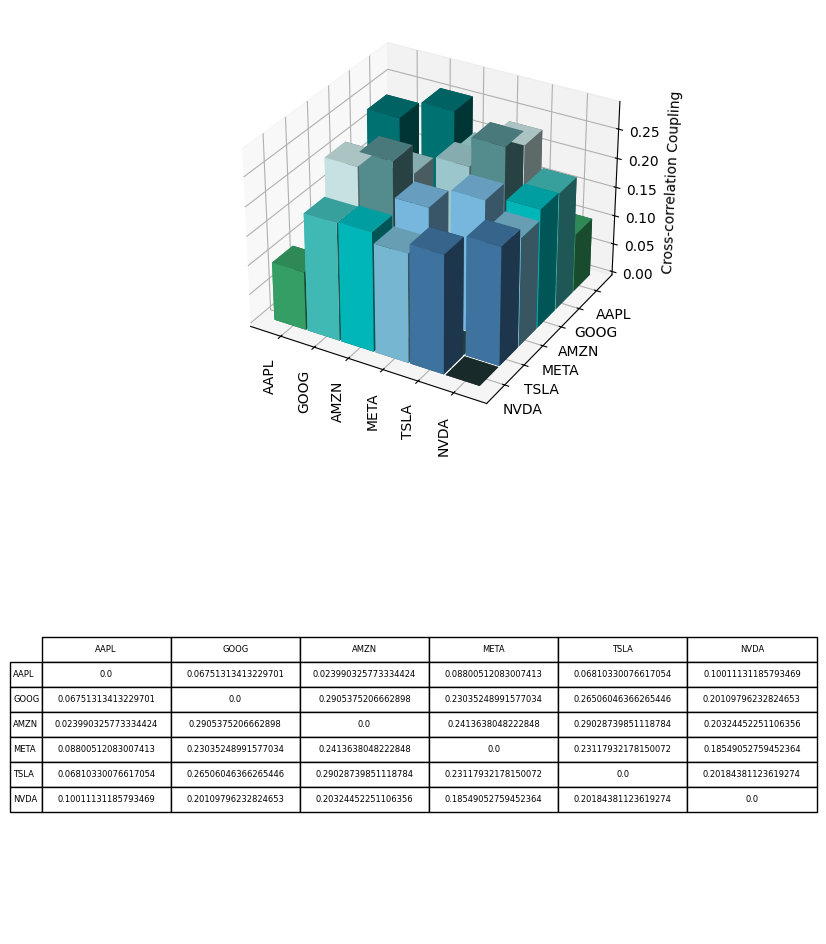

In [4]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.integrate import simps
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

ticker_symbol3 = "AMZN"
ticker_symbol4 = "META"
ticker_symbol5 = "TSLA"
ticker_symbol6 = "NVDA"

ticker_symbol3 = input(f"Enter the third ticker symbol (default: {ticker_symbol3}): ") or ticker_symbol3
ticker_symbol4 = input(f"Enter the fourth ticker symbol (default: {ticker_symbol4}): ") or ticker_symbol4
ticker_symbol5 = input(f"Enter the fifth ticker symbol (default: {ticker_symbol5}): ") or ticker_symbol5
ticker_symbol6 = input(f"Enter the sixth ticker symbol (default: {ticker_symbol6}): ") or ticker_symbol6

# Define the tickers and fetch historical data from Yahoo Finance
tickers = [ticker_symbol1, ticker_symbol2, ticker_symbol3, ticker_symbol4, ticker_symbol5, ticker_symbol6]
data_dict = {}

# Retrieve closing prices for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data_dict[ticker] = data['Close'].values[::-1].astype(np.float32)  # Reverse for chronological order

# Function to calculate G_{IJ}(\tau) for a dataset
def calculate_G_symmetrized(y, max_lag):
    N = len(y)
    G_values = []
    # Ensure max_lag does not exceed N - 1 to avoid division by zero
    max_lag = min(max_lag, N - 1)

    for tau in range(1, max_lag + 1):
        if N - tau == 0:
            break  # Prevent division by zero

        sum_1 = sum(y[n] * y[n + tau] for n in range(N - tau))
        sum_2 = sum(y[n + tau] * y[n] for n in range(N - tau))
        G_tau = 0.5 * (1 / (N - tau)) * (sum_1 + sum_2)
        G_values.append(G_tau)

    return np.array(G_values)

# Normalizes G values between -0.4 and 1
def normalize_G_values(G_values):
    min_val, max_val = np.min(G_values), np.max(G_values)
    G_values_normalized = (G_values - min_val) / (max_val - min_val)
    return -0.4 + G_values_normalized * (1 + 0.4)

# Model function
def model_function(t, phi, omega):
    return (1 / torch.sin(phi)) * torch.exp(-omega * t * torch.cos(phi)) * torch.sin(phi + omega * t * torch.sin(phi))

# Rescaled model function with lambda and eta
def adjusted_model_function(t, phi, omega, lambda_, eta):
    t_rescaled = lambda_ ** (1 - eta) * t ** eta
    return (1 / torch.sin(phi)) * torch.exp(-omega * t_rescaled * torch.cos(phi)) * torch.sin(phi + omega * t_rescaled * torch.sin(phi))

# Compute G values for each ticker and normalize
max_lag = 500
G_values_dict = {ticker: normalize_G_values(calculate_G_symmetrized(data, max_lag)) for ticker, data in data_dict.items()}

# Convert G values to PyTorch tensors
G_tensors = {ticker: torch.tensor(G_values).float().view(-1, 1) for ticker, G_values in G_values_dict.items()}
t_vals = np.linspace(0, 1, len(list(G_values_dict.values())[0])).astype(np.float32)
t_tensor = torch.tensor(t_vals).float().view(-1, 1)

# Model parameters
phis = [torch.tensor(1.0, requires_grad=True) for _ in range(6)]
omegas = [torch.tensor(1.0, requires_grad=True) for _ in range(6)]
lambda_ = torch.tensor(1.0, requires_grad=True)
eta = torch.tensor(1.0, requires_grad=True)

# Optimizer and loss function
optimizer = optim.Adam(phis + omegas + [lambda_, eta], lr=0.01)
loss_fn = nn.MSELoss()

# Fit each ticker model individually while sharing lambda and eta
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    losses = []
    for i, ticker in enumerate(tickers):
        y_fit = adjusted_model_function(t_tensor, phis[i], omegas[i], lambda_, eta)
        losses.append(loss_fn(y_fit, G_tensors[ticker]))
    total_loss = sum(losses)
    total_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item()}")

# Compute cross-correlation values for all pairs
cross_correlation_values = []
for i in range(6):
    for j in range(i + 1, 6):
        y_fit_i = adjusted_model_function(t_tensor, phis[i], omegas[i], lambda_, eta).detach().numpy().flatten()
        y_fit_j = adjusted_model_function(t_tensor, phis[j], omegas[j], lambda_, eta).detach().numpy().flatten()
        cross_correlation_values.append((tickers[i], tickers[j], simps(y_fit_i * y_fit_j, t_vals)))

# Plot cross-correlation values in a 3D bar graph
num_tickers = len(tickers)

# Populate cross_correlation_matrix with calculated cross-correlation values
cross_correlation_matrix = np.zeros((num_tickers, num_tickers))
for (ticker_i, ticker_j, cross_val) in cross_correlation_values:
    i = tickers.index(ticker_i)
    j = tickers.index(ticker_j)
    cross_correlation_matrix[i, j] = cross_val
    cross_correlation_matrix[j, i] = cross_val  # Symmetric

# Create a DataFrame below the bar plot
df_cross_correlation = pd.DataFrame(cross_correlation_matrix, index=tickers, columns=tickers)

# Create a 3D bar plot
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(211, projection='3d')  # Place plot in top half of figure

# Define x, y, z positions and the bar heights
x_pos, y_pos = np.meshgrid(np.arange(num_tickers), np.arange(num_tickers), indexing="ij")
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros_like(x_pos)

# Flatten the cross-correlation matrix for bar heights

bar_heights = np.flip(cross_correlation_matrix, axis=1)
bar_heights = bar_heights.flatten()

# Define bar width and depth
dx = dy = 0.95
dz = bar_heights

# Plot the bars in a 2D grid
colors=['mediumseagreen', 'mediumaquamarine', 'aquamarine', 'turquoise', 'lightseagreen', 'darkslategrey', 'mediumturquoise','lightcyan', 'paleturquoise', 'teal', 'darkslategrey', 'lightseagreen', 'darkturquoise', 'cadetblue', 'powderblue',
        'darkslategrey', 'teal', 'turquoise', 'skyblue', 'lightskyblue', 'darkslategrey', 'powderblue', 'paleturquoise', 'aquamarine', 'steelblue', 'darkslategrey', 'lightskyblue', 'cadetblue', 'lightcyan', 'mediumaquamarine', 'darkslategrey', 'steelblue',
        'skyblue', 'darkturquoise', 'mediumturquoise', 'mediumseagreen']

ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=colors, shade=True)

# Label the axes
ax.set_xticks(np.arange(num_tickers) + dx / 2)
ax.set_yticks(np.arange(num_tickers) + dy / 2)
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers[::-1])
ax.set_zlabel('Cross Correlation Coupling')

# Plot DataFrame below the 3D plot
ax2 = fig.add_subplot(212)  # Place DataFrame table in bottom half of figure
ax2.axis("tight")
ax2.axis("off")
table = ax2.table(cellText=df_cross_correlation.values, colLabels=tickers, rowLabels=tickers, loc="center", cellLoc="center")
table.scale(1, 1.5)  # Adjust table scaling for readability

plt.show()

#References
I.Baaquie BE. Quantum Field Theory for Economics and Finance. Cambridge University Press; 2018. https://www.cambridge.org/core/books/quantum-field-theory-for-economics-and-finance/4F182E56D8F55E14DC4BC1837765B1CF?pageNum=1&searchWithinIds=4F182E56D8F55E14DC4BC1837765B1CF&productType=BOOK_PART&searchWithinIds=4F182E56D8F55E14DC4BC1837765B1CF&productType=BOOK_PART&sort=mtdMetadata.bookPartMeta._mtdPositionSortable%3Aasc&pageSize=30&template=cambridge-core%2Fbook%2Fcontents%2Flistings&ignoreExclusions=true<br>
II. Baaquie BE. 2016 Statisticalmicroeconomics and commodity prices: theoryand empirical results. Phil. Trans. R. Soc. A 374:20150104.http://dx.doi.org/10.1098/rsta.2015.0104